### IS - Brand position
Finding Product position on Social Network (PPSN)

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import math
import string
import json
import pymongo
from itertools import groupby

In [2]:
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from pythainlp.corpus import thai_stopwords

# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\ProgramData\Anaconda3\lib\site-packages\_pytest\mark\structures.py:378: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [3]:
# Connect MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["NIDA_PPSN_PRD"]
col_thread = mydb["NIDA_PPSN_THREAD"]
col_comment = mydb["NIDA_PPSN_COMMENT"]

In [4]:
def reduced_keyword(wtkn,redCol):
    del_list = []
    ret_wtkn = wtkn
    for each in ret_wtkn:
        if each not in redCol:
            del_list.append(each)
    ret_wtkn = [x for x in ret_wtkn if x not in del_list]
    return ret_wtkn

### 3.Process หัวกระทู้เพื่อดึง Domain (Brand & Product) ไม่ใช้โมเดลเทรนแล้วทำนาย ต้องการความถูกต้อง 100%

In [5]:
cursor_thread = col_thread.find()
df_thr_process = pd.DataFrame(cursor_thread)

In [6]:
cursor_comment = col_comment.find()
df_cmt_process = pd.DataFrame(cursor_comment)

In [7]:
# จริงๆต้องใช้เงื่อนไข t_mention_brand.str.len() != 0 และ t_mention_dairy.str.len() != 0
df_urls_milk = df_thr_process[(df_thr_process.t_mention_brand.str.len() != 0) | (df_thr_process.t_mention_dairy.str.len() != 0)]
df_urls_milk['t_mention_brand'] = df_urls_milk['t_mention_brand'].apply(lambda x: repr(set(x)))
df_urls_milk['t_mention_product'] = df_urls_milk['t_mention_product'].apply(lambda x: repr(set(x)))

In [8]:
df_join_url = pd.merge(df_urls_milk,df_cmt_process,how='inner',on='URLs')

In [9]:
df_join_url.drop(columns=['_id_x','_id_y','headline_x'],inplace=True)

In [10]:
#df_join_url = pd.merge(df_urls_milk,df_cmt_process,how='inner',on='URLs')
#df_join_url.drop(columns=['_id_x','_id_y','headline_x'],inplace=True)
df_join_url.columns = ['URLs','token_headline','t_mention_dairy','t_mention_product','t_mention_brand'
                       ,'commentId','headline','text','Retrived_date','token_text','cmt_mention_dairy'
                       ,'cmt_mention_product','cmt_mention_brand']

In [11]:
df_join_url.head(3)

,URLs,token_headline,t_mention_dairy,t_mention_product,t_mention_brand,commentId,headline,text,Retrived_date,token_text,cmt_mention_dairy,cmt_mention_product,cmt_mention_brand
0,https://pantip.com/topic/39868603,"[นม, เมจิ, รสหวาน, หา]",[นม],{'รสหวาน'},{'เมจิ'},1,นมเมจิรสหวานทำไมหายากจังคะ,เมื่อก่อนหลายปีมาแล้ว ในเซเว่นยังมีนมเมจิรสหวา...,2020-11-29 00:13:26.571,"[ปี, 7-Eleven, ยังมี, นม, เมจิ, รสหวาน, ขาย, อ...","[นม, นม]","[รสหวาน, รสหวาน]",[เมจิ]
1,https://pantip.com/topic/39868603,"[นม, เมจิ, รสหวาน, หา]",[นม],{'รสหวาน'},{'เมจิ'},2,นมเมจิรสหวานทำไมหายากจังคะ,เบาหวานครับ แฮ่ๆ,2020-11-29 00:13:26.571,[เบาหวาน],[],[],[]
2,https://pantip.com/topic/39868603,"[นม, เมจิ, รสหวาน, หา]",[นม],{'รสหวาน'},{'เมจิ'},3,นมเมจิรสหวานทำไมหายากจังคะ,หาซื้อไม่ได้นี่คิดได้ 2 อย่างนะ. คนไม่ค่อย...,2020-11-29 00:13:26.571,"[หา, ซื้อไม่ได้, คิดได้, , คน, กินกัน, ไม่, ทำ...",[],[รสหวาน],[]


EDA#2

จาก Issue นี้จะพบว่าทำ Product position ได้ยาก แต่ทำ Brand position แทนได้ เนื่องจากสัดส่วนของข้อความที่มีการพูดถึง brand+flavor 
มีน้อยกว่าครึ่ง จึงให้ใช้วิธีเอา brand ของหัวกระทู้แปะไปในทุก comment แทน เพื่อทำ Brand Position ส่วน flavor จะกลายเป็น attribute ไป

###  4. (ยกเลิกแต่เก็บ code) คัดเลือกคำมาเป็น Attribute ด้วย TF-IDF

In [12]:
#import gensim
#from gensim.models import TfidfModel

In [13]:
# Create Bag of Word & calculate TF-IDF
#dictionary = gensim.corpora.Dictionary(df_join_url['token_text'])
#gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in df_join_url['token_text']]
#model = TfidfModel(gensim_corpus)
#vector = model[gensim_corpus]
#word_frequencies = [[(dictionary[id], tfidf_val) for id, tfidf_val in couple] for couple in vector]

In [14]:
#for i in range(0,len(word_frequencies)):
#    word_frequencies[i].sort(key=lambda tup:(-tup[1], tup[0]))  # SORT LIST of TUPLE DESCENDINGLY
#    word_frequencies[i] = word_frequencies[i][:10]   

In [15]:
# List complehension : get the first element of each tuple in a list
# https://www.kite.com/python/answers/how-to-get-the-first-element-of-each-tuple-in-a-list-in-python
#first_tuple_elements = [[a for a,tf in couple] for couple in word_frequencies]

In [16]:
#first_tuple_elements

### 4. คัดเลือกคำมาเป็น Attribute ด้วย LDAvis

https://radimrehurek.com/gensim/models/ldamodel.html

In [17]:
# Create Bag of Word & calculate TF-IDF
dictionary = gensim.corpora.Dictionary(df_join_url['token_text'])
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in df_join_url['token_text']]

In [57]:
num_topics = 8
chunksize = 5000                  # size of the doc looked at every pass
iterations = 100
eval_every = 1                    # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize \
                                     ,alpha='auto', eta='auto',iterations=iterations \
                                     ,num_topics=num_topics \
                                     ,eval_every=eval_every)

Wall time: 13.7 s


In [58]:
pyLDAvis.gensim.prepare(model, gensim_corpus, dictionary, R=40, lambda_step=0.05)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.081130 -0.000050       1        1  31.415663
4      0.027668  0.021211       2        1  19.364705
0      0.014774  0.022737       3        1  16.167612
6      0.060087  0.019114       4        1   8.781565
2      0.015611  0.012814       5        1   8.300386
3     -0.014983 -0.001211       6        1   6.221052
1     -0.151268  0.040162       7        1   5.365168
7     -0.033019 -0.114777       8        1   4.383849, topic_info=       Term         Freq        Total Category  logprob  loglift
23           5726.000000  5726.000000  Default  40.0000  40.0000
7        นม  6035.000000  6035.000000  Default  39.0000  39.0000
24      กิน  3936.000000  3936.000000  Default  38.0000  38.0000
35      ไม่  8369.000000  8369.000000  Default  37.0000  37.0000
126      //   595.000000   595.000000  Default  36.0000  36.0000
..      ...          ...          ...      ...      ...      ...
266  น้ำตาล    28.853515   595.231027   Topic8  -5.7929   0.1005
3       ขวด    30.133211   808.829256   Topic8  -5.7495  -0.1627
12       รส    29.262824   936.485340   Topic8  -5.7789  -0.3386
14       หา    28.387368   578.593038   Topic8  -5.8092   0.1126
41   ยี่ห้อ    27.898953  1386.388254   Topic8  -5.8266  -0.7786

[855 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
23        1  0.148955         
23        2  0.557928         
23        3  0.154369         
23        4  0.037370         
23        5  0.043132         
...     ...       ...      ...
88        7  0.012027      ไหม
88        8  0.024054      ไหม
8778      2  0.978370  ไอโอดีน
7862      7  0.798612      ๆคง
9324      6  0.741984  ๆๆๆๆๆๆๆ

[2101 rows x 3 columns], R=40, lambda_step=0.05, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 7, 3, 4, 2, 8])

### ทำ WordCloud เพื่ออธิบายแต่ละกลุ่มว่าเกี่ยวกับอะไร

In [42]:
cloud = WordCloud(font_path='thsarabunnew-webfont.ttf',background_color='white',max_words=40)

In [59]:
topics = model.show_topics(num_topics=8, num_words=300,formatted=False)

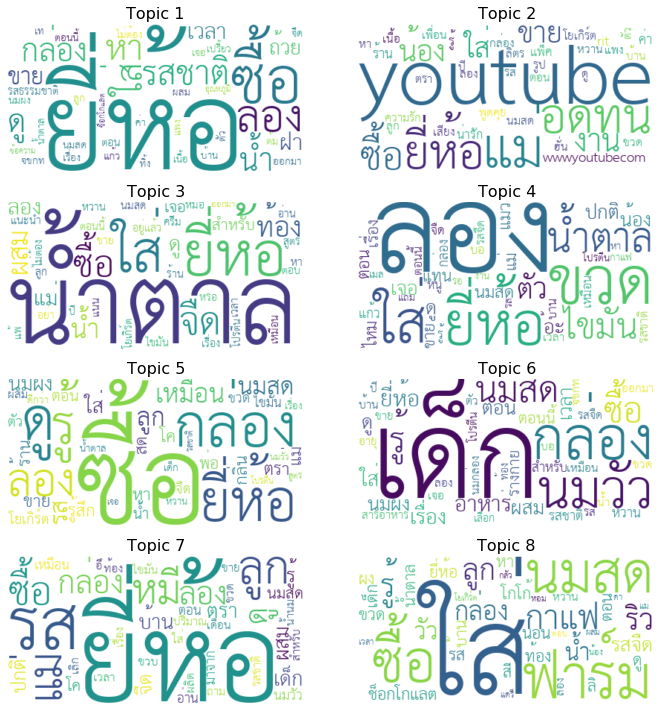

In [60]:
# REF: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
# ตัดเศษคำหรือเทอมที่ไม่ต้องการออกก่อน (บางตัวเป็นชื่อแบรนด์ stopword หรือ Strong Ties)
rem = {'กิน','กินนม','ทาน','อร่อย','ชอบ','ออ','ดื่ม','ดื่มนม','ขอบคุณ','นม','ดูด','ทำ','//','ริ','หล่อ','แบบนี้','อาทิตย์','สัปดาห์'
       ,' ','','ดี','ผม','คน','เค้า','กระทู้','เหมือนกัน','อ่ะ','คลิก','ที่ซ่อน','pantipcom','พี่'
       ,'ไทย','เดนมาร์ค','เดนมาร์ก','ดัชมิลล์','เมจิ','โฟร์โมสต์','โชคชัย'
       ,'แดรี่โฮม','เอ็มมิลค์','แมคโนเลีย','ไทยเดนมาร์ค','หนองโพ','คาเนชั่น','บีทาเก้น','จิตรลดา'
       ,'tops','makro','lotus','bigc','7-Eleven'}
th_stopwords = set(thai_stopwords()).union(rem)
minProb = 0.001
maxProb = 0.01

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = {a: b for a, b in topics[i][1] if a not in th_stopwords and (b >= minProb and b <= maxProb)}
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud,interpolation='bilinear',cmap=plt.cm.gray)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Export คำไปคัดเลือกอย่างละเอียด

In [ ]:
#Get the most relevant topics to the given word.
# Set probability = 0.0001

def get_topics_terms(topic, d, model):
    listofTup = []
    for tt_couple in model.get_topic_terms(topic, topn=10000):
        id_, prob = tt_couple
        listofTup.append((d[id_], prob))
    df = pd.DataFrame(listofTup)
    df.insert(0,'Topic',value=d[topic])
    df.columns = ['Topic','term','prob']
    return df.sort_values(by='prob', ascending=False)

In [ ]:
# ไล่เช็คทีละ Topic โดยเลือกจาก Top100 Prob แต่ละกลุ่ม และดูตัวที่สนใจ (ตามทบทวนวรรณกรรม)
# สุดที่ num_topics = 8 กลุ่ม

for i in range(0,8):
    if i ==0:
        df = get_topics_terms(i, dictionary, model)
    else:
        df = df.append(get_topics_terms(i, dictionary, model))

In [ ]:
df.drop_duplicates(subset='term', keep='first', inplace=True, ignore_index=True)

In [ ]:
df[['term','prob']].to_excel('uniqueText_Lev3.xlsx')

สรุปคำที่จะนำมาเป็น Attribute (รวม link ที่เป็นเคสยกเว้น)

In [ ]:
execption_urls = ['https://pantip.com/topic/30833944','https://pantip.com/topic/30105850','https://pantip.com/topic/35439062']

In [ ]:
attrributes = []

stores = ['tops','makro','lotus','bigc','7-Eleven']

products = ['สตรอว์เบอร์รี','ช็อกโกแลต','รสกาแฟ','รสหวาน','รสจืด','ไขมันต่ำ','ไขมัน 0%','ไฮโปรตีน','อัลมอนด์'
                ,'รสกล้วย','grass fed','นมฟรีแลคโตส','เมจิโกลด์','นมฮอกไกโด','เบดไทม์','ดาร์คช็อกโกแลต','ไฮแคลเซียม'
                ,'คาราเมล','มอลต์','เมล่อน','ชาเขียวมัจฉะ','บัลแกเรีย','รสธรรมชาติ','รสกลมกล่อม','ซากุระ','วิปครีม']

milk_kind=['นม','นมข้น','นมจืด','นมสด','กินนม','ดื่มนม','ขวดนม','นมวัว','นมกล่อง','ผลิตภันท์นม','น้ำนมโค'
                     ,'โยเกิร์ต','นมเปรี้ยว','uht','นมถั่วเหลือง','นมผง','พาสเจอร์ไรส์','nondairy','non dairy']

#  EDA ใน Excel ได้ flavor 68 ตัว (ถ้าดึงยี่ห้ออื่นก็เพิ่มอีก)
avai_flavs = ['เมจิเมจิโกลด์','เมจิเมล่อน','เมจิไขมัน 0%','เมจิไขมันต่ำ','เมจิไฮโปรตีน','เมจิช็อกโกแลต','เมจิชาเขียวมัจฉะ','เมจิดาร์คช็อกโกแลต'
 ,'เมจินมฟรีแลคโตส','เมจิบัลแกเรีย','เมจิมอลต์','เมจิรสกลมกล่อม','เมจิรสกล้วย','เมจิรกาแฟ','เมจิรสจืด','เมจิรสธรรมชาติ','เมจิรสหวาน'
 ,'เมจิสตรอว์เบอร์รี','เมจิอัลมอนด์','เอ็มมิลค์นมฟรีแลคโตส','เอ็มมิลค์รสจืด','แดรี่โฮมgrass fed','แดรี่โฮมเบดไทม์','แดรี่โฮมช็อกโกแลต'
 ,'แดรี่โฮมรสกล้วย','แดโฮมรสจืด','แดรี่โฮมรสหวาน','แดรี่โฮมสตรอว์เบอร์รี','แมคโนเลียไขมันต่ำ','แมคโนเลียช็อกโกแลต','แมคโนเลียรสจืด'
 ,'โชคชัยไขมันต่ำ','โชคชัยช็อกโกแลต','โชคชัยรสกาแฟ','โชคชัยรสจืด','โชคชัยสตรอว์เบอร์รี','ฟร์โมสต์ไขมัน 0%','โฟร์โมสต์ไขมันต่ำ'
 ,'โฟร์โมสต์คาราเมล','โฟร์โมสต์ช็อกโกแลต','โฟร์โมสต์รสกาแฟ','โฟร์โมสต์รสจืด','โฟร์โมสต์สตรอว์เบอร์รี','ไทยเดนมาร์คช็อกโกแลต'
 ,'ไทยเดนมาร์ครสกาแฟ','ไทยเดนมาร์ครสจืด','ไทยเดนมาร์ครสหวาน','ไทยเดนมาร์คสตรอว์เบอร์รี','คาเนชั่นรสจืด','จิตรลดาช็อกโกแลต'
 ,'จิตรลดารสจืด','จิตรลดารสหวาน','จิตรลดาสตรอว์เบอร์รี','ดัชมิลล์ไขมัน 0%','ดัชมิลล์ไขมันต่ำ','ดัชมิลล์ไฮโปรตีน','ดัชลล์อกกแลต'
 ,'ดัชมิลล์มอลต์','ดัชมิลล์รสกาแฟ','ดัชมิลล์รสจืด','ดัชมิลล์สตรอว์เบอร์รี','หนองโพไขมัน 0%','หนองโพไขมันต่ำ','หนองโพช็อกโกแลต'
 ,'หนองโพรสกาแฟ','หนองโพรสจืด','หนองโพรสหวาน','หนองโพสตรอว์เบอร์รี']

reduceCol = attrributes + stores + products
reduceCol_all = attrributes + stores + milk_kind + products

In [ ]:
print(len(attrributes))
print(len(reduceCol))

### 5.สร้าง (Reduce) Bag of word ด้วย dictionary.doc2bow จัดลง dataframe

In [ ]:
cursor_thread = col_thread.find()
df_thr_process = pd.DataFrame(cursor_thread)
cursor_comment = col_comment.find()
df_cmt_process = pd.DataFrame(cursor_comment)

In [ ]:
# คัด headline ที่พูดถึง domain นม
df_urls_milk = df_thr_process[(df_thr_process.t_mention_dairy.str.len() != 0) | (df_thr_process.URLs.isin(execption_urls))]
#df_urls_milk = df_thr_process[(df_thr_process.URLs.isin(execption_urls))]

In [ ]:
# เมื่อ join กันแล้ว คอมเม้นทุกคอมเม้นจะอยู่ใน domain นมทั้งหมด
df_join_url = pd.merge(df_urls_milk,df_cmt_process,how='inner',on='URLs')

In [ ]:
df_join_url.drop(columns=['_id_x','_id_y','headline_y'],inplace=True)
df_join_url.rename(columns={"headline_x":"headline"},inplace=True)

In [ ]:
df_join_url['token_text_reduce'] = df_join_url['token_text'].apply(lambda x: reduced_keyword(x, reduceCol))

### 6.ทำ Topic Modeling จาก Reduce BoW

6.1 สร้าง Bag of word

In [ ]:
#dictionary = gensim.corpora.Dictionary(df_join_url['token_text_reduce'])
#gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in df_join_url['token_text_reduce']]
#word_frequencies = [[(dictionary[id], frequence) for id, frequence in couple] for couple in gensim_corpus]
#id2word = dictionary.id2token

6.2 หา Optimal Dimension

In [ ]:
#mlp = r'E:/master_BADS/IS_BADS/Product-Position-SNA/mallet-2.0.8/'
#mlp = r'D:/development_TestCase/Product-Position-SNA/mallet-2.0.8/'
#import os
#from gensim.models.wrappers import LdaMallet
#from gensim.models import CoherenceModel
#os.environ.update({'MALLET_HOME':mlp})

In [ ]:
#mallet_path = "D:/development_TestCase/Product-Position-SNA/mallet-2.0.8/bin/mallet"
#mallet_path = "E:/master_BADS/IS_BADS/Product-Position-SNA/mallet-2.0.8/bin/mallet"
#limit=20; start=1; step=1;
#coherence_values = []
#model_list = []
#for num_topics in range(start, limit, step):
#    model = LdaMallet(mallet_path, corpus=gensim_corpus, num_topics=num_topics, id2word=id2word)
#    model_list.append(model)
#    coherencemodel = CoherenceModel(model=model, texts=df_join_url['token_text_reduce'], dictionary=dictionary, coherence='c_v')
#    coherence_values.append(coherencemodel.get_coherence())

In [ ]:
#coherence_values

In [ ]:
#model.show_topics(formatted=False)

In [ ]:
# Show graph
#x = range(start, limit, step)
#plt.plot(x, coherence_values)
#plt.xlabel("Num Topics")
#plt.ylabel("Coherence score")
#plt.legend(("coherence_values"), loc='best')
#plt.show()

In [ ]:
# Print the coherence scores
#for m, cv in zip(x, coherence_values):
#    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

6.3 สร้าง LdaModel ตามกลุ่มที่หาได้

In [ ]:
#num_topics = 9
#chunksize = 6000                  # size of the doc looked at every pass
#iterations = 50
#eval_every = 1                    # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
#id2word = dictionary.id2token

#%time model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize \
#                                     ,alpha='auto', eta='auto',iterations=iterations \
#                                     ,num_topics=num_topics \
#                                     , eval_every=eval_every)

In [ ]:
#pyLDAvis.gensim.prepare(model, gensim_corpus, dictionary, R=40, lambda_step=0.1)
#pyLDAvis.gensim.prepare(model, gensim_corpus, dictionary, R=40, lambda_step=0.1, mds='tsne')

In [ ]:
topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=20)] for n in range(0, model.num_topics)]
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, model.num_topics+1)] )
topics_df